In [1]:
from enum import Enum
import math
class PayoffType(str, Enum):
    Call = 'Call'
    Put = 'Put'

def oneStepBinomial(S:float, r:float, u:float, d:float, optType:PayoffType, K:float, T:float) -> float:
    p = (math.exp(r*T) - d) / (u - d)
    if optType == PayoffType.Call:
        return math.exp(-r*T) * (p * max(S*u-K, 0) + (1 - p) * max(S*d-K, 0))

In [2]:
oneStepBinomial(S = 100, r = 0.01, u = 1.2, d = 0.8, optType = PayoffType.Call, K = 105, T = 1)

7.798504987524955

In [3]:
def cnorm(x):
    return (1 + math.erf(x / math.sqrt(2)))/2

def bsPrice(S, r, vol, T, strike, payoffType):
    fwd = S * math.exp(r * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    else:
        raise Exception("not supported payoff type", payoffType)

In [5]:
S, r, vol, K, T, u, d = 100, 0.01, 0.2, 105, 1.0, 1.2, 0.8
print('blackPrice: ', bsPrice(S, r, vol, T, K, PayoffType.Call))
print('oneStepTree: ', oneStepBinomial(S, r, u, d, PayoffType.Call, K, T))

blackPrice:  6.297254539086019
oneStepTree:  7.798504987524955


In [6]:
def oneStepBinomial2(S, r, vol, optType, K, T):
    b = math.exp(vol * vol * T+r*T) + math.exp(-r * T)
    u = (b + math.sqrt(b*b - 4)) / 2
    d = 1/u
    p = (math.exp(r * T) - d) / (u-d)
    if optType == PayoffType.Call:
        return math.exp(-r * T) * (p * max(S * u - K, 0) + (1-p) * max(S * d - K, 0))

In [8]:
# test ---
S,r,vol,K,T,u,d = 100, 0.01, 0.2, 105, 1.0, 1.2, 0.8
print("blackPrice: ", bsPrice(S, r, vol, T, K, PayoffType.Call))
print("oneStepTree1: \t", oneStepBinomial(S, r, u, d, PayoffType.Call, K, T))
print("oneStepTree2: \t", oneStepBinomial2(S, r, vol, PayoffType.Call, K, T))

blackPrice:  6.297254539086019
oneStepTree1: 	 7.798504987524955
oneStepTree2: 	 8.212289615248919


In [37]:
def crrBinomial(S, r, vol, payoffType, K, T, n):
    t = T / n
    b = math.exp(vol * vol * t+r*t) + math.exp(-r * t)
    u = (b + math.sqrt(b*b - 4)) / 2
    p = (math.exp(r * t) - (1/u)) / (u - 1/u)
    # set up the last time slice, there are n+1 nodes at the last time slice
    payoffDict = {
        PayoffType.Call: lambda s: max(s-K, 0),
        PayoffType.Put: lambda s: max(K-s, 0),
    }
    vs = [payoffDict[payoffType]( S * u**(n-i-i)) for i in range(n+1)]
    # iterate backward
    for i in range(n-1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i+1):
            vs[j] = math.exp(-r * t) * (vs[j] * p + vs[j+1] * (1-p))
    return vs[0]

In [38]:
# test ---
S, r, vol, K, T = 100, 0.01, 0.2, 105, 1.0
print("blackPrice: \t", bsPrice(S, r, vol, T, K, PayoffType.Call))
print("crrNStepTree: \t", crrBinomial(S, r, vol, PayoffType.Call, K, T, 300))

blackPrice: 	 6.297254539086019
crrNStepTree: 	 6.296057152109465


In [39]:
import matplotlib.pyplot as plt
n = 300
S, r, vol, K, T = 100, 0.01, 0.2, 105, 1.0
bsPrc = bsPrice(S, r, vol, T, K, PayoffType.Call)
crrErrs = [(crrBinomial(S,r,vol,PayoffType.Call,K,T,i) - bsPrc) for i in range(1, n)]

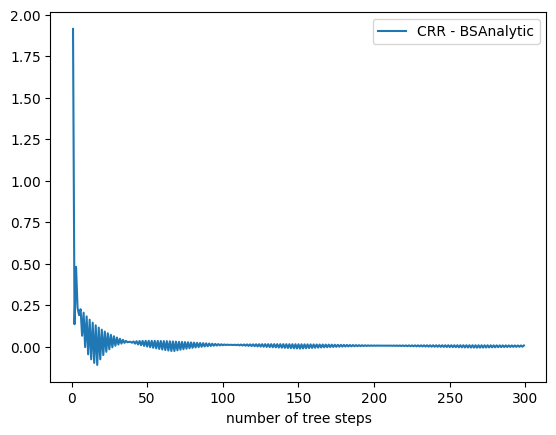

In [40]:
plt.plot(range(1, n), crrErrs, label = "CRR - BSAnalytic")
plt.xlabel('number of tree steps')
plt.legend()
# plt.yscale('log')
plt.show()

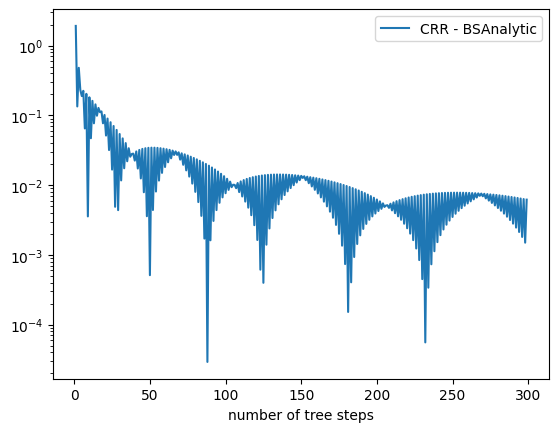

In [31]:
import matplotlib.pyplot as plt
n = 300
S, r, vol, K, T = 100, 0.01, 0.2, 105, 1.0
bsPrc = bsPrice(S, r, vol, T, K, PayoffType.Call)
crrErrs = [abs(crrBinomial(S,r,vol,PayoffType.Call,K,T,i) - bsPrc) for i in range(1, n)] # abs error here
plt.plot(range(1, n), crrErrs, label = "CRR - BSAnalytic")
plt.xlabel('number of tree steps')
plt.yscale('log') # plot on log scale
plt.legend()

In [ ]:
def crrBinomialAmer(S, r, vol, payoffType, K, T, n):
    # set up tree
    # set up last time slice payoff

    #iterate backward
    for i in range(n-1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i+1):
            # here we deal with Amercian early exercise:
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j+1] * (1-p))
            vs[j] = max(continuation, payoffDict[payoffType](S * u**(i-j-j)))
    return vs[0]

In [49]:
class EuropeanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception('payoffType not supported: ', self.payoffType)
    def valueAtNode(self, t, S, continuation):
        return continuation

In [48]:
class AmericanOption():
    def __init__(self, expiry, strike, payoffType):
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception('payoffType not supported: ', self.payoffType)
    # step 6 in tree algo, exercise logic
    def valueAtNode(self, t, S, continuation):
        return max(self.payoff(S), continuation)

In [46]:
def crrBinomialG(S, r, vol, trade, n):
    t = trade.expiry / n
    b = math.exp(vol * vol * t+r*t) + math.exp(-r * t)
    u = (b + math.sqrt(b*b - 4)) / 2
    p = (math.exp(r * t) - (1/u)) / (u - 1/u)
    # d = 1 / u
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff( S * u**(n-i-i)) for i in range(n+1)]
    # iterate backward
    for i in range(n-1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i+1):
            nodeS = S * u**(i-j-j)
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j+1] * (1-p))
            vs[j] = trade.valueAtNode(t*i, nodeS, continuation)
    return vs[0]

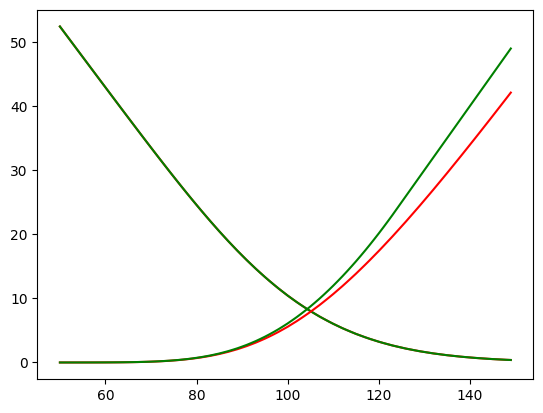

In [50]:
euroPrc, amerPrc = [], []
S, r, vol = 100, 0.05, 0.2
ks = range(50, 150)
for k in ks:
    euroPrc.append(crrBinomialG(S, r, vol, EuropeanOption(1, float(k), PayoffType.Call), 300))
    amerPrc.append(crrBinomialG(S, r, vol, AmericanOption(1, float(k), PayoffType.Call), 300))
plt.plot(ks, euroPrc, 'r', label = 'euroCall')
plt.plot(ks, amerPrc, 'g', label = 'amerCall')

euroPrc, amerPrc = [], []
for k in ks:
    euroPrc.append(crrBinomialG(S, r, vol, EuropeanOption(1, float(k), PayoffType.Put), 300))
    amerPrc.append(crrBinomialG(S, r, vol, AmericanOption(1, float(k), PayoffType.Put), 300))
plt.plot(ks, euroPrc, 'r', label = 'euroPut')
plt.plot(ks, amerPrc, 'g', label = 'amerPut')

In [51]:
class EuropeanPayoff():
    def __init__(self, expiry, payoffFun):
        self.expiry = expiry
        self.payoffFun = payoffFun
    def payoff(self, S):
        return self.payoffFun(S)
    def valueAtNode(self, t, S, continuation):
        return continuation

class AmercianPayoff():
    def __init__(self, expiry, payoffFun):
        self.expiry = expiry
        self.payoffFun = payoffFun
    def payoff(self, S):
        return self.payoffFun(S)
    def valueAtNode(self, t, S, continuation):
        return max(self.payoff(S), continuation)

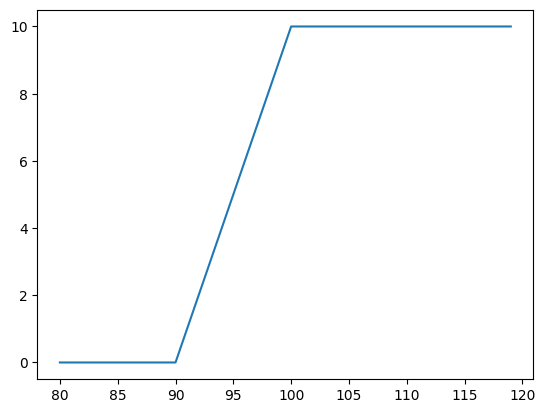

Euro callspread:  6.259190489574921
Amer callspread:  10.0


In [62]:
S, r, vol = 100, 0.05, 0.2
callSpread = lambda S: min(max(S-90, 0), 10)
plt.plot(range(80, 120), [callSpread(i) for i in range(80, 120)])
plt.show()

print("Euro callspread: ", crrBinomialG(S, r, vol, EuropeanPayoff(1, callSpread), 300))
print("Amer callspread: ", crrBinomialG(S, r, vol, AmercianPayoff(1, callSpread), 300))

In [65]:
class BarrierOption():
    def __init__(self, downBarrier, upBarrier, barrierStart, barrierEnd, underlyingOption):
        self.underlyingOption = underlyingOption
        self.barrierStart = barrierStart
        self.barrierEnd = barrierEnd
        self.downBarrier = downBarrier
        self.upBarrier = upBarrier
        self.expiry = underlyingOption.expiry
    def payoff(self, S):
        return self.underlyingOption.payoff(S)
    def valueAtNode(self, t, S, continuation):
        if t > self.barrierStart and t < self.barrierEnd:
            if self.upBarrier != None and S > self.upBarrier:
                return 0
            elif self.downBarrier != None and S < self.downBarrier:
                return 0
        return continuation

In [68]:
euroPrc

42.121029570626234

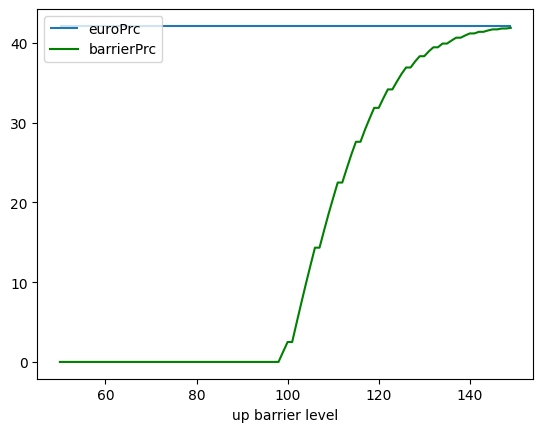

In [66]:
# varying up barrier
S, r, vol, K = 100, 0.05, 0.2, 105
eurOpt = EuropeanOption(1, k, PayoffType.Put)
euroPrc = crrBinomialG(S, r, vol, eurOpt, 300)
barrierPrc, ks = [], range(50, 150)
for barrierLevel in ks:
    prc = crrBinomialG(S, r, vol, BarrierOption(barrierStart = 0, barrierEnd = 1.0, downBarrier = None,
                                                upBarrier = barrierLevel, underlyingOption = eurOpt), n = 300)
    barrierPrc.append(prc)


plt.hlines(euroPrc, ks[0], ks[-1], label = 'euroPrc')
plt.plot(ks, barrierPrc, 'g', label='barrierPrc')
plt.xlabel('up barrier level')
plt.legend()
plt.show()

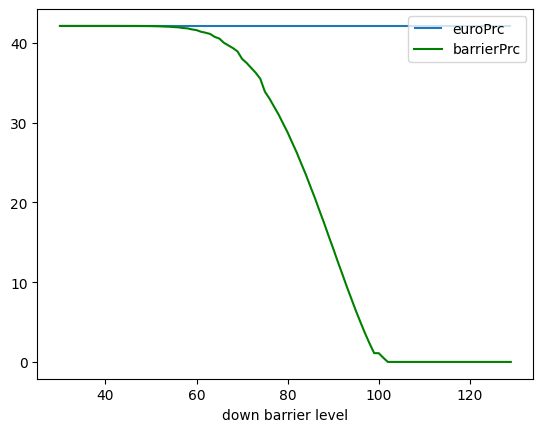

In [69]:
# varying down barrier
S, r, vol, K = 100, 0.05, 0.2, 105
eurOpt = EuropeanOption(1, k, PayoffType.Put)
euroPrc = crrBinomialG(S, r, vol, eurOpt, 300)
barrierPrc, ks = [], range(30, 130)
for barrierLevel in ks:
    prc = crrBinomialG(S, r, vol, BarrierOption(barrierStart = 0, barrierEnd = 1.0, downBarrier = barrierLevel, 
                                                upBarrier = None, underlyingOption = eurOpt), n = 300)
    barrierPrc.append(prc)
plt.hlines(euroPrc, ks[0], ks[-1], label = 'euroPrc')
plt.plot(ks, barrierPrc, 'g', label='barrierPrc')
plt.xlabel('down barrier level')
plt.legend()

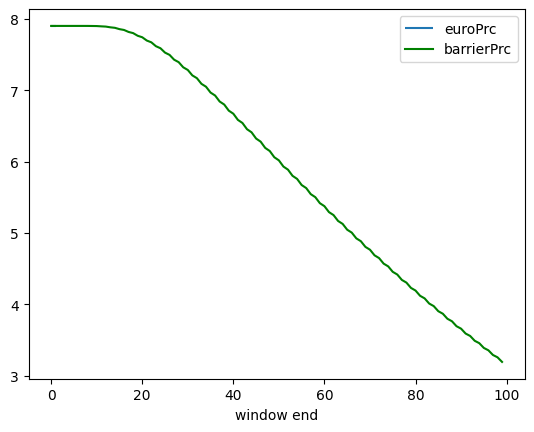

In [71]:
# varying barrier window, barrier end
S, r, vol, k = 100, 0.05, 0.2, 105
eurOpt = EuropeanOption(1, k, PayoffType.Put)
euroPrc = crrBinomialG(S, r, vol, eurOpt, 300)
barrierPrc = []
ks = range(0, 100)
for t in ks:
    prc = crrBinomialG(S, r, vol, BarrierOption(barrierStart = 0, barrierEnd = t / 100.0, downBarrier = 80,
                                                upBarrier = 150, underlyingOption = eurOpt), n = 300)
    barrierPrc.append(prc)
    
plt.hlines(euroPrc, ks[0], ks[-1] / 100, label = 'euroPrc')
plt.plot(ks, barrierPrc, 'g', label= 'barrierPrc')
plt.legend()
plt.xlabel('window end')
plt.show()

In [73]:
def binomialPricer(S, r, vol, trade, n, calib):
    t = trade.expiry / n
    (u, d, p) = calib(r, vol, t)
    # set up the last time slice, there are n+1 nodes at the last time slice
    vs = [trade.payoff(S * u ** (n - i) * d ** i) for i in range(n + 1)]
    # iterate backward
    for i in range(n - 1, -1, -1):
        # calculate the value of each node at time slide i, there are i nodes
        for j in range(i + 1):
            nodeS = S * u ** (i - j) * d ** j
            continuation = math.exp(-r * t) * (vs[j] * p + vs[j + 1] * (1 - p))
            vs[j] = trade.valueAtNode(t * i, nodeS, continuation)
    return vs[0]

In [74]:
def crrCalib(r, vol, t):
    b = math.exp(vol * vol * t + r * t) + math.exp(-r * t)
    u = (b + math.sqrt(b * b - 4)) / 2
    p = (math.exp(r * t) - (1 / u)) / (u - 1 / u)
    return (u, 1/u, p)

def jrrnCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def jreqCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    return (u, d, 1/2)

def tianCalib(r, vol, t):
    v = math.exp(vol * vol * t)
    u = 0.5 * math.exp(r * t) * v * (v + 1 + math.sqrt(v*v + 2*v - 3))
    d = 0.5 * math.exp(r * t) * v * (v + 1 - math.sqrt(v*v + 2*v - 3))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

In [75]:
def testBTrees():
    opt = EuropeanOption(1, 105, PayoffType.Call)
    S, r, vol = 100, 0.01, 0.2

    bsprc = bsPrice(S, r, vol, opt.expiry, opt.strike, opt.payoffType)
    print("bsPrice = \t ", bsprc)
    n = 300

    crrErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, crrCalib) - bsprc)) for i in range(1, n)]
    jrrnErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, jrrnCalib) - bsprc)) for i in range(1, n)]
    jreqErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, jreqCalib) - bsprc)) for i in range(1, n)]
    tianErrs = [math.log(abs(binomialPricer(S, r, vol, opt, i, tianCalib) - bsprc)) for i in range(1, n)]

    plt.plot(range(1, n), crrErrs, label="crr")
    plt.plot(range(1, n), jrrnErrs, label="jrrn")
    plt.plot(range(1, n), jreqErrs, label="jreq")
    plt.plot(range(1, n), tianErrs, label="tian")
    plt.legend()
    plt.show()

bsPrice = 	  6.297254539086019


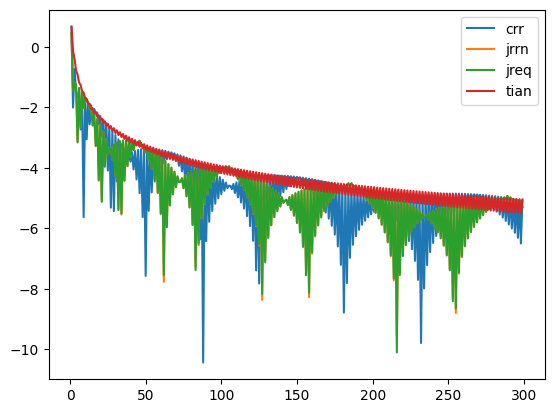

In [76]:
testBTrees()